In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

class HopfieldNetwork:
    def __init__(self, n_neurons=64):
        """
        Initialize a Hopfield network with n_neurons
        
        Parameters:
        -----------
        n_neurons : int
            Number of neurons in the network (default: 64)
        """
        self.n_neurons = n_neurons
        self.W = np.zeros((n_neurons, n_neurons))
        self.patterns = []
        self.cmap = colors.ListedColormap(['black', 'white',])
        self.norm = colors.BoundaryNorm([-1.5, 0, 1.5], self.cmap.N)
    
    def add_pattern(self, pattern):
        """
        Add a pattern to the network and update the weight matrix
        
        Parameters:
        -----------
        pattern : ndarray
            Binary pattern of shape (n_neurons,)
        """
        if len(pattern) != self.n_neurons:
            raise ValueError(f"Pattern size must be {self.n_neurons}")
        
        # Store the pattern
        self.patterns.append(pattern.copy())
        
        # Update weight matrix using outer product
        self.W += np.outer(pattern, pattern) / self.n_neurons
        
        # Set diagonal elements to zero (no self-connections)
        np.fill_diagonal(self.W, 0)
    
    def update_weights_from_patterns(self):
        """
        Update the weight matrix based on all stored patterns
        """
        self.W = np.zeros((self.n_neurons, self.n_neurons))
        for pattern in self.patterns:
            self.W += np.outer(pattern, pattern) / self.n_neurons
        np.fill_diagonal(self.W, 0)
    
    def simulate(self, initial_state, n_steps=50, dt=0.1, noise_sigma=0.1):
        """
        Simulate the network dynamics
        
        Parameters:
        -----------
        initial_state : ndarray
            Initial state of the network
        n_steps : int
            Number of time steps to simulate
        dt : float
            Time step size
        noise_sigma : float
            Noise amplitude
        
        Returns:
        --------
        states : ndarray
            Network states over time
        """
        x = initial_state.copy()
        states = np.zeros((n_steps + 1, self.n_neurons))
        states[0] = x
        
        for t in range(n_steps):
            # Generate Gaussian noise
            noise = noise_sigma * np.random.randn(self.n_neurons) * np.sqrt(dt)
            
            # Update rule: dx/dt = -x + f(Wx) + noise
            total_input = np.dot(self.W, x)
            activation = np.sign(total_input)  # Activation function
            
            # Euler integration
            x = x + dt * (-x + activation) + noise
            states[t + 1] = x
            
        return states
    
    def activation_function(self, s):
        """
        Activation function for the Hopfield network
        
        Parameters:
        -----------
        s : ndarray
            Input to neurons
            
        Returns:
        --------
        activation : ndarray
            Output of neurons
        """
        return np.sign(s)
    
    def create_random_pattern(self, seed=None):
        """
        Create a random pattern with values -1 or 1
        
        Parameters:
        -----------
        seed : int or None
            Random seed for reproducibility
            
        Returns:
        --------
        pattern : ndarray
            Binary pattern of shape (n_neurons,)
        """
        if seed is not None:
            np.random.seed(seed)
        
        return 2 * np.random.randint(2, size=self.n_neurons) - 1
    
    def corrupt_pattern(self, pattern, corruption_level=0.2, seed=None):
        """
        Corrupt a pattern by flipping a fraction of its bits
        
        Parameters:
        -----------
        pattern : ndarray
            Original pattern
        corruption_level : float
            Fraction of bits to flip (0 to 1)
        seed : int or None
            Random seed for reproducibility
            
        Returns:
        --------
        corrupted : ndarray
            Corrupted pattern
        """
        if seed is not None:
            np.random.seed(seed)
        
        corrupted = pattern.copy()
        n_flip = int(corruption_level * self.n_neurons)
        flip_indices = np.random.choice(self.n_neurons, n_flip, replace=False)
        corrupted[flip_indices] *= -1
        
        return corrupted
    
    def vector_to_matrix(self, vector):
        """
        Convert a vector to a square matrix
        
        Parameters:
        -----------
        vector : ndarray
            Vector of shape (n_neurons,)
            
        Returns:
        --------
        matrix : ndarray
            Matrix of shape (sqrt(n_neurons), sqrt(n_neurons))
        """
        side_length = int(np.sqrt(self.n_neurons))
        return vector.reshape(side_length, side_length)
    
    def matrix_to_vector(self, matrix):
        """
        Convert a square matrix to a vector
        
        Parameters:
        -----------
        matrix : ndarray
            Matrix of shape (sqrt(n_neurons), sqrt(n_neurons))
            
        Returns:
        --------
        vector : ndarray
            Vector of shape (n_neurons,)
        """
        return matrix.flatten()
    
    def plot_pattern(self, pattern, title=None):
        """
        Plot a pattern as an 8x8 grid
        
        Parameters:
        -----------
        pattern : ndarray
            Pattern to plot
        title : str or None
            Title for the plot
        """
        pattern_matrix = self.vector_to_matrix(pattern)
        
        plt.figure(figsize=(4, 4))
        plt.imshow(pattern_matrix, cmap=self.cmap, norm=self.norm)
        plt.grid(True, color='gray', linestyle='-', linewidth=0.5)
        if title:
            plt.title(title)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('./latex/' + title + '.png', bbox_inches='tight')
        plt.show()
    
    def plot_weight_matrix(self, title=None):
        """
        Plot the weight matrix
        """
        plt.figure(figsize=(6, 6))
        plt.imshow(self.W, cmap='RdBu_r')
        plt.colorbar(label='Weight Value')
        if title:
            plt.title(title)

        plt.tight_layout()
        plt.savefig('./latex/' + title + '.png', bbox_inches='tight')
        plt.show()
    
    def plot_network_activity(self, states, sample_steps=10, filename=None):
        """
        Plot the network activity over time
        
        Parameters:
        -----------
        states : ndarray
            Network states over time
        sample_steps : int
            Number of time steps to sample
        """
        n_steps = states.shape[0]
        step_size = max(1, n_steps // sample_steps)
        sampled_steps = range(0, n_steps, step_size)
        
        fig, axes = plt.subplots(1, len(sampled_steps), figsize=(2*len(sampled_steps), 2))
        
        for i, step in enumerate(sampled_steps):
            state_matrix = self.vector_to_matrix(states[step])
            axes[i].imshow(state_matrix, cmap=self.cmap, norm=self.norm)
            axes[i].set_title(f'Step {step}')
            axes[i].axis('off')
        
        plt.tight_layout()
        if filename:
            plt.savefig('./latex/'+ filename +'.png', bbox_inches='tight')
        plt.show()
    
    def calculate_overlap(self, state, pattern):
        """
        Calculate the overlap between a state and a pattern
        
        Parameters:
        -----------
        state : ndarray
            Network state
        pattern : ndarray
            Pattern to compare with
            
        Returns:
        --------
        overlap : float
            Overlap between state and pattern
        """
        return np.dot(state, pattern) / self.n_neurons
    
    def test_pattern_recovery(self, pattern, corruption_level=0.2, n_steps=50):
        """
        Test if the network can recover a corrupted pattern
        
        Parameters:
        -----------
        pattern : ndarray
            Original pattern
        corruption_level : float
            Fraction of bits to flip
        n_steps : int
            Number of simulation steps
            
        Returns:
        --------
        recovered : bool
            Whether the pattern was recovered
        final_overlap : float
            Final overlap with the original pattern
        """
        corrupted = self.corrupt_pattern(pattern, corruption_level)
        
        states = self.simulate(corrupted, n_steps=n_steps)
        final_state = states[-1]
        final_state_discrete = np.sign(final_state)
        
        # Calculate overlap with the original pattern
        overlap = self.calculate_overlap(final_state_discrete, pattern)
        
        # Check if pattern was recovered (overlap > 0.9)
        recovered = overlap > 0.95
        
        return recovered, overlap
    
    def measure_capacity(self, n_patterns_range, trials_per_pattern=10, corruption_level=0.2):
        """
        Measure the network capacity by testing recovery success with increasing patterns
        
        Parameters:
        -----------
        n_patterns_range : list or range
            Range of number of patterns to test
        trials_per_pattern : int
            Number of trials per pattern count
        corruption_level : float
            Fraction of bits to flip
            
        Returns:
        --------
        results : dict
            Dictionary with results
        """
        results = {
            'n_patterns': [],
            'recovery_rate': []
        }
        
        for n_patterns in n_patterns_range:
            # Reset network
            self.W = np.zeros((self.n_neurons, self.n_neurons))
            self.patterns = []
            
            # Create and store patterns
            for _ in range(n_patterns):
                pattern = self.create_random_pattern()
                self.add_pattern(pattern)
            
            # Test recovery for each pattern
            success_count = 0
            total_trials = n_patterns * trials_per_pattern
            
            for i in range(n_patterns):
                pattern = self.patterns[i]
                for _ in range(trials_per_pattern):
                    recovered, _ = self.test_pattern_recovery(pattern, corruption_level)
                    if recovered:
                        success_count += 1
            
            recovery_rate = success_count / total_trials
            results['n_patterns'].append(n_patterns)
            results['recovery_rate'].append(recovery_rate)
            
            print(f"Number of patterns: {n_patterns}, Recovery rate: {recovery_rate:.2f}")
        
        return results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



Exercise 3.1: Creating and visualizing a pattern


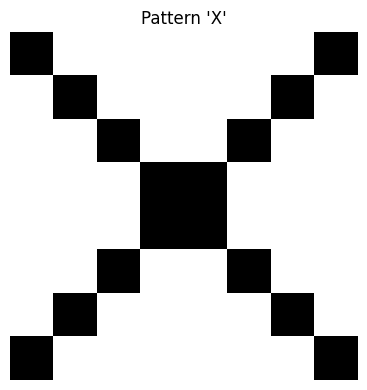

In [25]:

# Exercise 3.1: Create and visualize a pattern
print("\nExercise 3.1: Creating and visualizing a pattern")
# Create a simple pattern (e.g., a letter or symbol)
# Create a pattern for adidas logo (three stripes)


# Main script to solve exercises 3.1 through 3.6

# Initialize Hopfield network with 64 neurons
hopfield = HopfieldNetwork(n_neurons=64)

pattern_matrix = np.ones((8, 8))
for i in range(8):
    pattern_matrix[i, i] = -1
    pattern_matrix[i, 7-i] = -1

# Convert matrix to vector
pattern = hopfield.matrix_to_vector(pattern_matrix)

# Add pattern to the network
hopfield.add_pattern(pattern)

# Visualize the pattern
hopfield.plot_pattern(pattern, title="Pattern 'X'")




Exercise 3.2: Plotting weight matrix and simulating dynamics


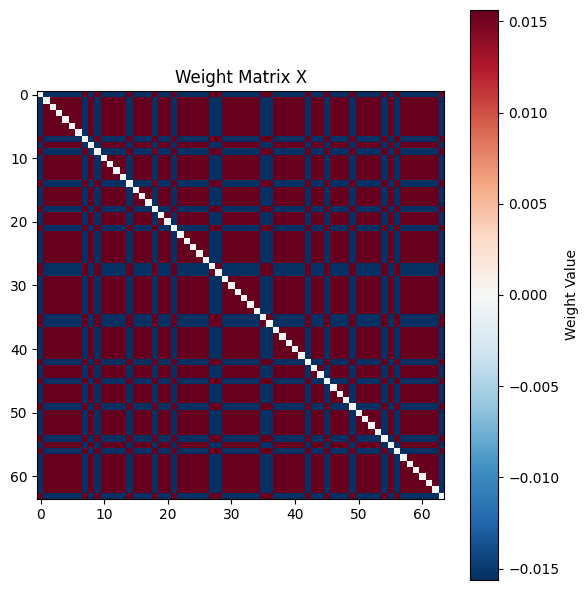

Simulating with random initial conditions...


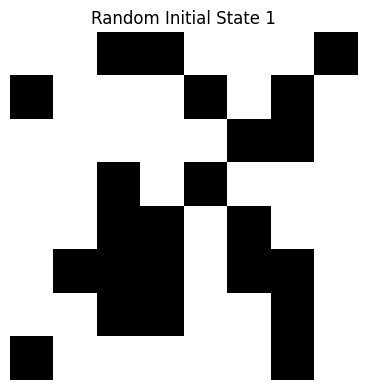

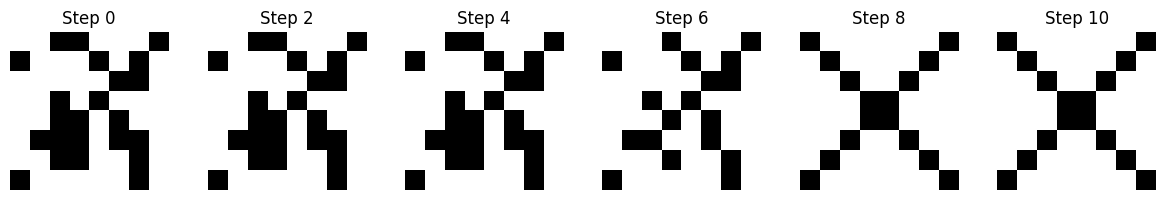

In [27]:
# Exercise 3.2: Plot W and simulate dynamics
print("\nExercise 3.2: Plotting weight matrix and simulating dynamics")
# Plot weight matrix
hopfield.plot_weight_matrix(title="Weight Matrix X")

# Simulate with random initial conditions
print("Simulating with random initial conditions...")
initial_state = hopfield.create_random_pattern()

# Plot initial state
hopfield.plot_pattern(initial_state, title="Random Initial State 1")

# Simulate dynamics
states = hopfield.simulate(initial_state, n_steps=10, dt=0.1, noise_sigma=0.1)

# Plot network activity at sampled time steps
hopfield.plot_network_activity(states, sample_steps=5, filename="Network Activity X1")




Exercise 3.3: Observing fixed points
Running multiple simulations to identify fixed points...

Simulation 1:


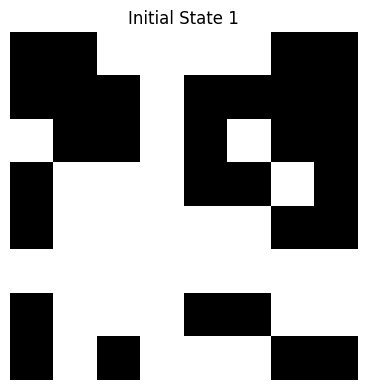

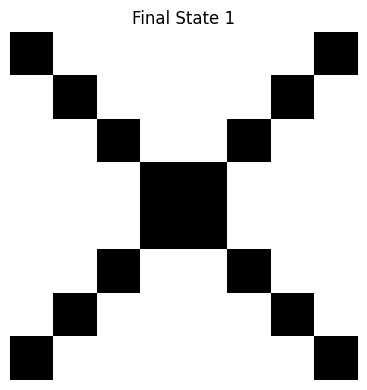

Overlap with stored pattern: 1.0000

Simulation 2:


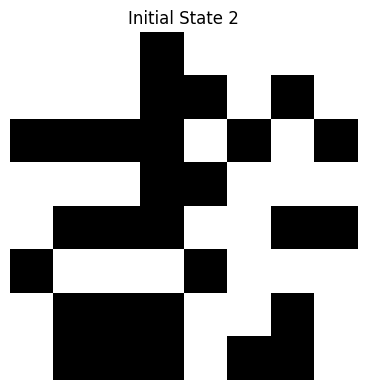

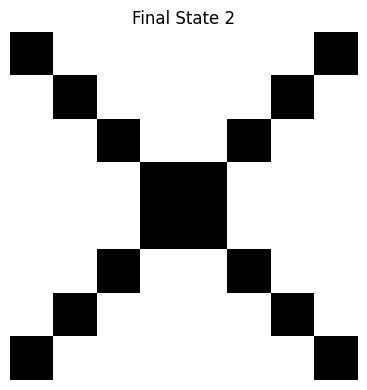

Overlap with stored pattern: 1.0000

Simulation 3:


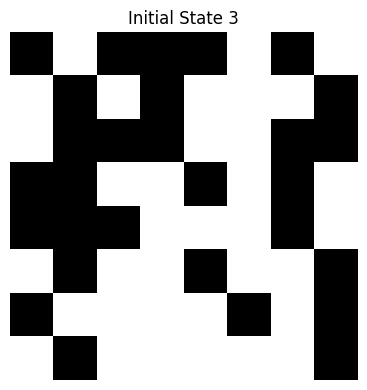

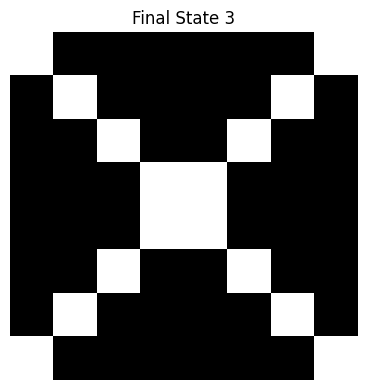

Overlap with stored pattern: -1.0000


In [28]:

# Exercise 3.3: Fixed points
print("\nExercise 3.3: Observing fixed points")
# Run multiple simulations with different initial conditions
print("Running multiple simulations to identify fixed points...")

for i in range(3):
    print(f"\nSimulation {i+1}:")
    initial_state = hopfield.create_random_pattern(seed=i+100)
    hopfield.plot_pattern(initial_state, title=f"Initial State {i+1}")
    
    states = hopfield.simulate(initial_state, n_steps=50, dt=0.1, noise_sigma=0.1)
    final_state = states[-1]
    
    hopfield.plot_pattern(final_state, title=f"Final State {i+1}")
    
    # Calculate overlap with stored pattern
    overlap = hopfield.calculate_overlap(np.sign(final_state), pattern)
    print(f"Overlap with stored pattern: {overlap:.4f}")




Exercise 3.4: Adding a second pattern


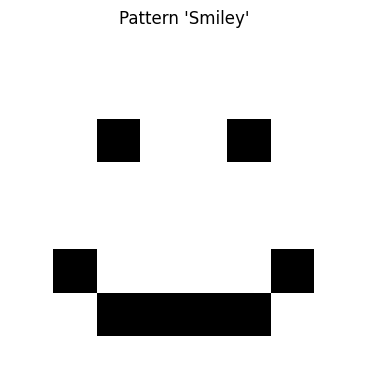

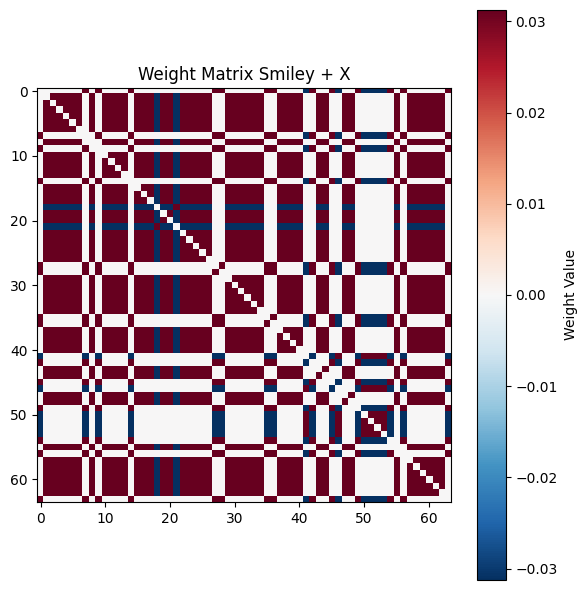

In [29]:

# Exercise 3.4: Introduce a new pattern
print("\nExercise 3.4: Adding a second pattern")

# Create a pattern for a smiley face
pattern2_matrix = np.ones((8, 8))
# Eyes
pattern2_matrix[2, 2] = -1
pattern2_matrix[2, 5] = -1
# Smile (curved mouth)
pattern2_matrix[5, 1] = -1
pattern2_matrix[6, 2] = -1
pattern2_matrix[6, 3] = -1
pattern2_matrix[6, 4] = -1
pattern2_matrix[6, 5] = -1
pattern2_matrix[5, 6] = -1



# Convert to vector and add to the network
pattern2 = hopfield.matrix_to_vector(pattern2_matrix)

# Visualize the second pattern
hopfield.plot_pattern(pattern2, title="Pattern 'Smiley'")

# Add the second pattern to the network
hopfield.patterns = [pattern]  # Reset patterns
hopfield.add_pattern(pattern2)

# Update weights with both patterns
hopfield.update_weights_from_patterns()

# Plot new weight matrix
hopfield.plot_weight_matrix(title="Weight Matrix Smiley + X")


Simulating with both patterns...


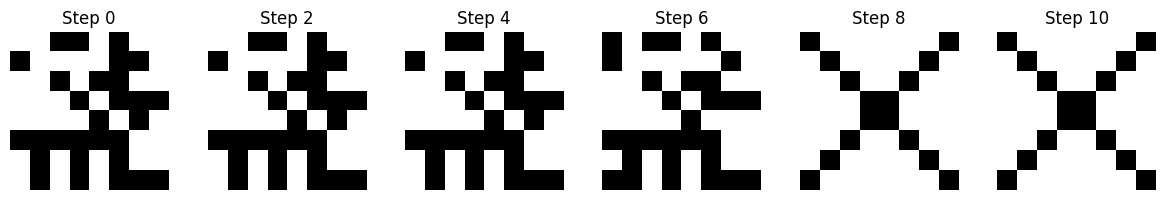

Overlap with pattern 'X': 1.0000
Overlap with pattern 'O': 0.3750


In [58]:
# Simulate with random initial conditions
print("Simulating with both patterns...")
initial_state = hopfield.create_random_pattern(seed=10002020)
# hopfield.plot_pattern(initial_state, title="Random Initial State")

states = hopfield.simulate(initial_state, n_steps=10, dt=0.1, noise_sigma=0.1)
final_state = states[-1]

# hopfield.plot_pattern(final_state, title="Final State")
hopfield.plot_network_activity(states, sample_steps=5, 
                               filename="Network Converge X"
                               )

# Calculate overlap with both patterns
overlap1 = hopfield.calculate_overlap(np.sign(final_state), pattern)
overlap2 = hopfield.calculate_overlap(np.sign(final_state), pattern2)
print(f"Overlap with pattern 'X': {overlap1:.4f}")
print(f"Overlap with pattern 'O': {overlap2:.4f}")


Exercise 3.5: Pattern recovery from corrupted input


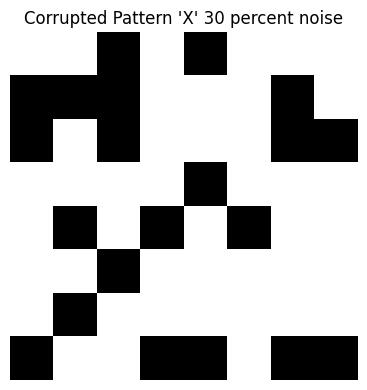

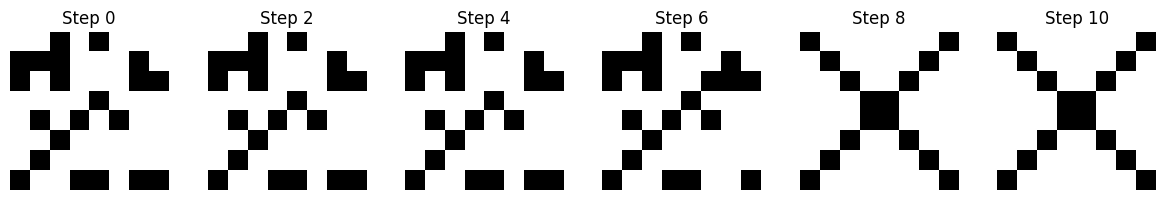

Final overlap with original pattern: 1.0000


In [70]:

# Exercise 3.5: Pattern recovery from corrupted input
print("\nExercise 3.5: Pattern recovery from corrupted input")
# Corrupt the first pattern
corruption_level = 0.3
corrupted_pattern = hopfield.corrupt_pattern(pattern, corruption_level)

# Visualize the corrupted pattern
hopfield.plot_pattern(corrupted_pattern, title=f"Corrupted Pattern 'X' {corruption_level*100:.0f} percent noise")

# Simulate with corrupted pattern as initial condition
states = hopfield.simulate(corrupted_pattern, n_steps=10, dt=0.1, noise_sigma=0.1)
final_state = states[-1]

# Plot network activity at sampled time steps
hopfield.plot_network_activity(states, sample_steps=5, filename="Network Activity Corrupted X")

# Calculate overlap with the original pattern
overlap = hopfield.calculate_overlap(np.sign(final_state), pattern)
print(f"Final overlap with original pattern: {overlap:.4f}")



Exercise 3.6: Testing network capacity
Number of patterns: 1, Recovery rate: 1.00
Number of patterns: 2, Recovery rate: 1.00
Number of patterns: 3, Recovery rate: 0.97
Number of patterns: 4, Recovery rate: 0.93
Number of patterns: 5, Recovery rate: 0.80
Number of patterns: 6, Recovery rate: 0.84
Number of patterns: 7, Recovery rate: 0.88
Number of patterns: 8, Recovery rate: 0.67
Number of patterns: 9, Recovery rate: 0.43
Number of patterns: 10, Recovery rate: 0.37
Number of patterns: 11, Recovery rate: 0.34
Number of patterns: 12, Recovery rate: 0.19
Number of patterns: 13, Recovery rate: 0.07
Number of patterns: 14, Recovery rate: 0.04
Number of patterns: 15, Recovery rate: 0.06
Number of patterns: 16, Recovery rate: 0.04
Number of patterns: 17, Recovery rate: 0.01
Number of patterns: 18, Recovery rate: 0.01
Number of patterns: 19, Recovery rate: 0.01
Number of patterns: 20, Recovery rate: 0.03


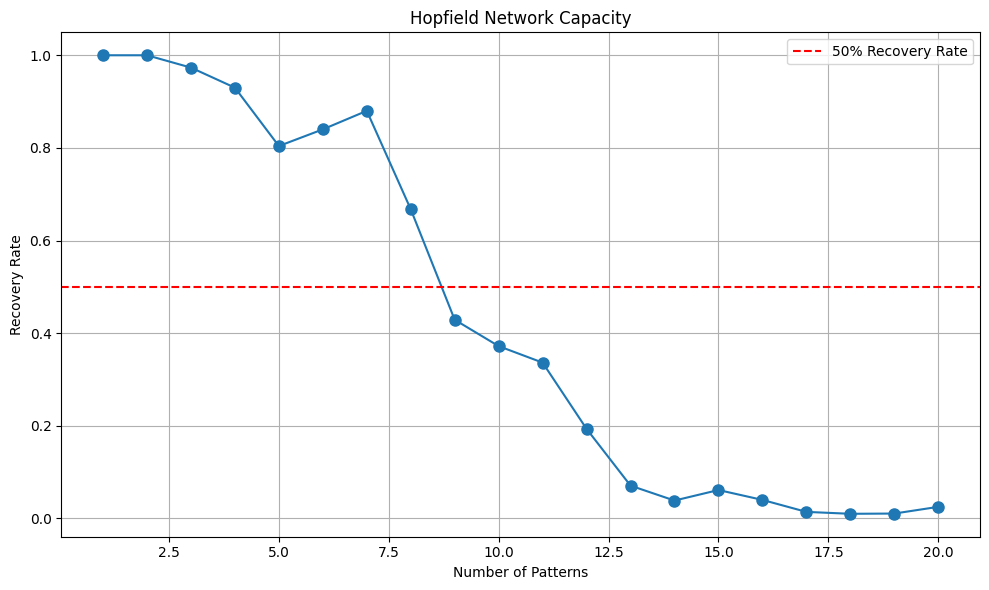

Theoretical capacity for 64 neurons: ~8.8 patterns
Empirical capacity (recovery rate < 50%): ~9 patterns


In [82]:

# Exercise 3.6: Network capacity
print("\nExercise 3.6: Testing network capacity")
# Reset the network
hopfield = HopfieldNetwork(n_neurons=64)

# Test network capacity by adding more patterns
n_patterns_range = range(1, 21)  # Test up to 20 patterns
results = hopfield.measure_capacity(n_patterns_range, trials_per_pattern=50, corruption_level=0.3)

# Plot capacity results
plt.figure(figsize=(10, 6))
plt.plot(results['n_patterns'], results['recovery_rate'], 'o-', markersize=8)
plt.axhline(y=0.5, color='r', linestyle='--', label='50% Recovery Rate')
plt.grid(True)
plt.xlabel('Number of Patterns')
plt.ylabel('Recovery Rate')
plt.title('Hopfield Network Capacity')
plt.legend()
plt.tight_layout()
plt.savefig('./latex/capacity_curve.png', bbox_inches='tight')
plt.show()

# Theoretical capacity is approximately 0.14N
theoretical_capacity = 0.138 * hopfield.n_neurons
print(f"Theoretical capacity for {hopfield.n_neurons} neurons: ~{theoretical_capacity:.1f} patterns")

# Find approximate empirical capacity (where recovery rate drops below 50%)
recovery_rates = np.array(results['recovery_rate'])
n_patterns = np.array(results['n_patterns'])
capacity_index = np.where(recovery_rates < 0.5)[0]

if len(capacity_index) > 0:
    empirical_capacity = n_patterns[capacity_index[0]]
    print(f"Empirical capacity (recovery rate < 50%): ~{empirical_capacity} patterns")
else:
    print("Empirical capacity not reached in tests")